In [1]:
from google.cloud import bigquery
client = bigquery.Client()

In [34]:
pip install pandas-gbq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 2.3 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 1.34.1
    Uninstalling google-api-core-1.34.1:
      Successfully uninstalled google-api-core-1.34.1
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-python-client 1.8.0 requires google-api-core<2dev,>=1.13.0, but you have google-api-core 2.19.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
from pandas_gbq import to_gbq
import sys
import os
import warnings
import nltk
import re
import spacy
sp = spacy.load('en_core_web_sm')
import tensorflow as tf
import seaborn as sns
from IPython.display import display
from langdetect import detect, LangDetectException
import matplotlib.pyplot as plt

In [3]:
query = """
    SELECT *
    FROM `nth-cumulus-423923-f9.Yelp.Resturant_Reviews`
    LIMIT 10000
"""

df = client.query(query).to_dataframe()


In [4]:
display(df.head(5))

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,categories,hours,review_id,user_id,review_stars,useful,funny,cool,text,date
0,siwG4ZM7RjUDO52DI84m3w,Ray's Vegan Soul,,St. Petersburg,FL,,27.767601,-82.640292,5.0,5,...,Restaurants,None,qJG2cyWB4MDuNhOjLrqDlA,cU-Qzs1NbOnOOgSesySfWA,5,0,0,0,Met Ray in front of Plant Love Ice Cream servi...,2021-03-28 17:37:13
1,jnTnR_eN7hGc7GGzGdUt9Q,The Waffle Boss,,Nashville,TN,,36.166667,-86.783333,4.0,6,...,Restaurants,None,iM0AVPPRuUXd-bRoUbl_rg,YK1s8btsKMzBqspb8BLgyw,5,0,0,0,We were having a bad day in Nashville. The sk...,2014-02-08 20:50:05
2,jnTnR_eN7hGc7GGzGdUt9Q,The Waffle Boss,,Nashville,TN,,36.166667,-86.783333,4.0,6,...,Restaurants,None,oUUANuZxbFIaJRyIp5UwmQ,7yuBjruAJfk0n0eTFONMSg,5,0,0,0,Can I give 6 stars? I LOVE this food truck. Ch...,2013-11-28 07:22:11
3,e6CioliBbGNk4xqSEw0x-A,Fireside Bar and Grill,7240 118 Avenue,Edmonton,AB,T5E,53.570395,-113.453486,1.5,14,...,Restaurants,"{""Tuesday"": ""8:30-23:0"", ""Wednesday"": ""8:30-23...",wYUfTm-WToy-JUNSG-FcxA,Sil8_tXtSH8MTF4jho6Pkg,1,0,0,0,Can not give less than 1 star. Did not even ge...,2015-04-12 00:34:46
4,e6CioliBbGNk4xqSEw0x-A,Fireside Bar and Grill,7240 118 Avenue,Edmonton,AB,T5E,53.570395,-113.453486,1.5,14,...,Restaurants,"{""Tuesday"": ""8:30-23:0"", ""Wednesday"": ""8:30-23...",-CgpMC9Z7hNHBh3v9WyGKA,Vd9jXofhWxSFsmtzn4NwRg,1,0,0,0,We went here for lunch and ended up leaving be...,2015-09-27 19:59:54


In [5]:
print(df.memory_usage(deep=True).sum())
print(df.shape)
print(df.columns)

25050461
(10000, 22)
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id',
       'review_stars', 'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')


In [6]:
cols_to_drop = ['name','address','city','state', 'postal_code',
                'latitude', 'longitude', 'review_id', 'review_count', 
                'is_open','postal_code', 'user_id', 'useful', 'funny', 'cool', 'date'] 
cols_to_keep = ['stars', 'text', 'categories']

In [7]:
df = df[cols_to_keep]
df.head(20)

,stars,text,categories
0,5.0,Met Ray in front of Plant Love Ice Cream servi...,Restaurants
1,4.0,We were having a bad day in Nashville. The sk...,Restaurants
2,4.0,Can I give 6 stars? I LOVE this food truck. Ch...,Restaurants
3,1.5,Can not give less than 1 star. Did not even ge...,Restaurants
4,1.5,We went here for lunch and ended up leaving be...,Restaurants
5,3.0,Very very disappointed small hamburger size co...,Restaurants
6,3.0,"I'll say this, they deliver quick. I read a lo...",Restaurants
7,3.0,We ordered take out. The Dinners for 3 people ...,Restaurants
8,3.0,Ordered delivery via Skip the Dishes based on ...,Restaurants
9,3.0,NEVER EVER EAT HERE\n... unless you like wasti...,Restaurants


In [8]:
print(df.shape)
print(df.columns)

(10000, 3)
Index(['stars', 'text', 'categories'], dtype='object')


In [9]:
df['text'] = df['text'].str.strip()
df = df[df['text'] != '']

In [10]:
df.isnull().values.any()

False

In [11]:
def safe_detect(text):
    try:
        if text.strip(): 
            return detect(text)
        else:
            return 'unknown'
    except LangDetectException:
        return 'unknown'

df['detect'] = df['text'].apply(safe_detect)
df = df[df['detect'] == 'en'].reset_index(drop=True)

In [12]:
print(df.shape)
print(df.columns)

(9994, 4)
Index(['stars', 'text', 'categories', 'detect'], dtype='object')


In [13]:
df.head(20)

,stars,text,categories,detect
0,5.0,Met Ray in front of Plant Love Ice Cream servi...,Restaurants,en
1,4.0,We were having a bad day in Nashville. The sk...,Restaurants,en
2,4.0,Can I give 6 stars? I LOVE this food truck. Ch...,Restaurants,en
3,1.5,Can not give less than 1 star. Did not even ge...,Restaurants,en
4,1.5,We went here for lunch and ended up leaving be...,Restaurants,en
5,3.0,Very very disappointed small hamburger size co...,Restaurants,en
6,3.0,"I'll say this, they deliver quick. I read a lo...",Restaurants,en
7,3.0,We ordered take out. The Dinners for 3 people ...,Restaurants,en
8,3.0,Ordered delivery via Skip the Dishes based on ...,Restaurants,en
9,3.0,NEVER EVER EAT HERE\n... unless you like wasti...,Restaurants,en


In [14]:
df_final = df.drop_duplicates(inplace=False)
df_final.shape

(9987, 4)

In [15]:
df_final.head(10)

,stars,text,categories,detect
0,5.0,Met Ray in front of Plant Love Ice Cream servi...,Restaurants,en
1,4.0,We were having a bad day in Nashville. The sk...,Restaurants,en
2,4.0,Can I give 6 stars? I LOVE this food truck. Ch...,Restaurants,en
3,1.5,Can not give less than 1 star. Did not even ge...,Restaurants,en
4,1.5,We went here for lunch and ended up leaving be...,Restaurants,en
5,3.0,Very very disappointed small hamburger size co...,Restaurants,en
6,3.0,"I'll say this, they deliver quick. I read a lo...",Restaurants,en
7,3.0,We ordered take out. The Dinners for 3 people ...,Restaurants,en
8,3.0,Ordered delivery via Skip the Dishes based on ...,Restaurants,en
9,3.0,NEVER EVER EAT HERE\n... unless you like wasti...,Restaurants,en


In [16]:
df_final = df_final[(df_final["stars"]!=3)]
df_final.head(20)

,stars,text,categories,detect
0,5.0,Met Ray in front of Plant Love Ice Cream servi...,Restaurants,en
1,4.0,We were having a bad day in Nashville. The sk...,Restaurants,en
2,4.0,Can I give 6 stars? I LOVE this food truck. Ch...,Restaurants,en
3,1.5,Can not give less than 1 star. Did not even ge...,Restaurants,en
4,1.5,We went here for lunch and ended up leaving be...,Restaurants,en
11,2.0,"Service is ridiculously slow, food is overpric...",Restaurants,en
12,2.0,In the downtown core and quick for lunch. Serv...,Restaurants,en
13,2.0,Service was atrocious. There is a really nice...,Restaurants,en
14,2.0,Nice location. Good atmosphere. But the staff ...,Restaurants,en
15,2.0,"Was okay, just stopped in for a beer. Beware ...",Restaurants,en


In [17]:
df_final.loc[df_final['stars']<3,'sentiment']=0
df_final.loc[df_final['stars']>3,'sentiment']=1
df_final.drop('stars', axis=1, inplace=True)
df_final.head(20)

,text,categories,detect,sentiment
0,Met Ray in front of Plant Love Ice Cream servi...,Restaurants,en,1.0
1,We were having a bad day in Nashville. The sk...,Restaurants,en,1.0
2,Can I give 6 stars? I LOVE this food truck. Ch...,Restaurants,en,1.0
3,Can not give less than 1 star. Did not even ge...,Restaurants,en,0.0
4,We went here for lunch and ended up leaving be...,Restaurants,en,0.0
11,"Service is ridiculously slow, food is overpric...",Restaurants,en,0.0
12,In the downtown core and quick for lunch. Serv...,Restaurants,en,0.0
13,Service was atrocious. There is a really nice...,Restaurants,en,0.0
14,Nice location. Good atmosphere. But the staff ...,Restaurants,en,0.0
15,"Was okay, just stopped in for a beer. Beware ...",Restaurants,en,0.0


In [18]:
df_final.dtypes

text           object
categories     object
detect         object
sentiment     float64
dtype: object

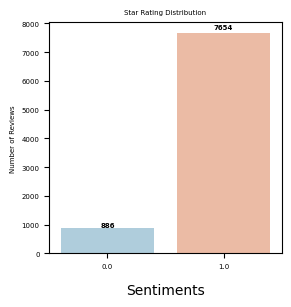

In [23]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    
plt.figure(figsize=(3,3))
grouped = df_final.sentiment.value_counts().sort_index()
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Sentiments', labelpad=10, fontsize=10)
plt.ylabel('Number of Reviews', fontsize=5)
plt.title('Star Rating Distribution', fontsize=5)
plt.tick_params(labelsize=5)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=5)



In [25]:
from sklearn.utils import resample

In [26]:
df_majority=df_final[(df_final['sentiment']==1)]
df_minority=df_final[(df_final['sentiment']==0)]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,   
                                 n_samples=7654, # to match majority class
                                 random_state=42)
df_final = pd.concat([df_minority_upsampled, df_majority])

In [27]:
df_final.sentiment.value_counts()


sentiment
0.0    7654
1.0    7654
Name: count, dtype: int64

In [28]:
df_final = df_final.reset_index(drop=True)
df_final.head(10)

,text,categories,detect,sentiment
0,Worst meal I have had in a long time. Initiall...,Restaurants,en,0.0
1,"They sell OLD BUD BOTTLES, to people, then ser...",Restaurants,en,0.0
2,Waited for 30 minutes and the food still sucke...,Restaurants,en,0.0
3,I asked to substitute fries for a side salad a...,Restaurants,en,0.0
4,Can I give 'no stars' as we did not sample any...,Restaurants,en,0.0
5,"I've been here 5 or 6 times. Overall, this pl...",Restaurants,en,0.0
6,We walked in and walked right out. The doors ...,Restaurants,en,0.0
7,Subpar dining experiences are made worse when ...,Restaurants,en,0.0
8,I specifically stopped ordering from here a ye...,Restaurants,en,0.0
9,My favorite place to eat.. They make the best ...,Restaurants,en,0.0


In [29]:
sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

exclude_stopwords = ['no','not']
for word in exclude_stopwords:
    stopwords.remove(word)

In [30]:
def spacy_process(text):
    doc=sp(text)
    
    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)
        
    filtered_sentence =[] 
    for word in lemma_list:
        lexeme = sp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    lower_words = []
    for word in filtered_sentence:
        text_letters_only = re.sub("[^a-zA-Z]", " ", word) 
        text_words_lower = text_letters_only.lower()  
        lower_words.append(text_words_lower)
    text_final = " ".join(lower_words)
    return  " ".join(text_final.split())

In [31]:
spacy_process(df_final['text'][10])

'clean friendly area come look gourmet food bother want greasy food good ice cream near list server try hard young kid possibly work job expression fit'

In [ ]:
chunksize = 10000  

# Define your BigQuery project ID and table name
project_id = 'nth-cumulus-423923-f9'
table_id = 'Yelp.Cleaned_Reviews'

# Define a function to process a chunk of data and upload to BigQuery
def process_and_upload(chunk, table_id):
    chunk['cleaned_reviews'] = chunk['text'].apply(spacy_process)
    to_gbq(chunk, table_id, project_id=project_id, if_exists='append')

In [38]:
chunksize = 1000  

project_id = 'nth-cumulus-423923-f9'
table_id = 'Yelp.Cleaned_Reviews'

def process_and_upload(chunk, table_id):
    chunk['cleaned_reviews'] = chunk['text'].apply(spacy_process)
    to_gbq(chunk, table_id, project_id=project_id, if_exists='append')

for start in range(0, len(df_final), chunksize):
    chunk = df_final.iloc[start:start + chunksize]
    process_and_upload(chunk, table_id)

100%|██████████| 1/1 [00:00<00:00, 7710.12it/s]


In [39]:
query = """
    SELECT *
    FROM `nth-cumulus-423923-f9.Yelp.Cleaned_Reviews`
"""
df_2 = client.query(query).to_dataframe()

In [40]:
df_2.isnull().values.any()

False

In [41]:
df_2.head()

,text,categories,detect,sentiment,cleaned_reviews
0,"Order was supposed to be done at 7:45, I order...",Restaurants,en,0.0,order suppose order wait minute walk minute wo...
1,This place has never changed still messes up o...,Restaurants,en,0.0,place change mess order not care customer fail...
2,This place has never changed still messes up o...,Restaurants,en,0.0,place change mess order not care customer fail...
3,i love fridays that are in south jersey. my f...,Restaurants,en,0.0,love friday south jersey favorite food brownie...
4,I love Chipotle.\n\nEnd of story.\n\nCoworker ...,Restaurants,en,0.0,love chipotle end story coworker decide order ...


In [42]:
df_2 = df_2[['cleaned_reviews','sentiment']]

In [44]:
df_2.to_csv('gs://instance-20240524-125953/df_2.csv', index=False)

FileNotFoundError: https://storage.googleapis.com/upload/storage/v1/b/instance-20240524-125953/o